# Coursework 2

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

In [78]:
import numpy
from matplotlib import pyplot, animation
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (10,6)

import scipy
from scipy.optimize import minimize_scalar, minimize

from IPython.core.display import HTML

import types

from copy import deepcopy

## Agents - training the flock

A flock of boids is trained in small groups to find the "best" cohesion parameter $C$. This training is done by starting a flock of four boids at the locations $[0.5 \pm 0.25, 0.5 \pm 0.25]$ with initial velocities $[1, 1]$. The parameters $A = 5, S = 1/4$ are always used. The parameter $C$ is chosen to minimize the variance in the average width of the flock when they evolve up to $t=5$ with timesteps $\Delta t = 0.1$.

Once the flock is trained, we need to check the impact on a "proper" flock.

### Tasks

1. Given the training flock as above, use `scipy`'s `minimize_scalar` routine or equivalent to compute the best value of the parameter $C$ in the range $[0.1, 10]$. You may find the `numpy.var` routine useful for computing the variance.
2. Once you have trained the boids, create (as in the lab) a flock of $50$ agents randomly distributed within $[0, 5]^2$. Give them initial velocities of $(1, 1) + 10^{-2} {\bf v}_r$, where ${\bf v}_r$ is a random velocity with each component a uniform random number in $[0, 1]$. Evolve the flock using timesteps of $0.05$ for $200$ steps and plot the flock behaviour. Also plot the "width" of the flock.

In [79]:
# the initial time & time step
t = 5
dt = 0.1

In [80]:
def set_up_locations4():
    """
    Function that creates the initial flock in order to obtain the C for minimum variance.
    
    @Parameters
    NONE
    
    @Returns
    flock - np array
            array containing the initial position of the the test flock.
    """
    flock = numpy.zeros([4, 2])
    flock[0] = [0.75, 0.75]
    flock[1] = [0.75, 0.25]
    flock[2] = [0.25, 0.75]
    flock[3] = [0.25, 0.25]
    
    return flock

In [162]:
class Agent(object):
    """
    Class that defines the agent in a crowd. 
    The agent will assert it's loccation against a set of neighbours, and move with the group.
    
    Main author: Dr. Ian Hawke. 
    """
    def __init__(self, location, velocity, C=1, A=5, S=0.25):
        """
        Initialisation of the class.
        
        @parameters
        location - np array (2)
                the location of the agent as x & y coordinates
                
        velocity - np array (2)
                the velocity of the agent on x & y axis
                
        C - float
            parameters used in calculating the direction of movement
            
        A - float
            parameters used in calculating the direction of movement
        
        S - float
            parameters used in calculating the direction of movement
        """
        assert type(location) == numpy.ndarray or type(location) == list, \
            "Location is not the proper type in Agents. It is a {}.".format(type(location))
        if type(location) == numpy.ndarray:
            assert location.shape == (2,), \
                "location is not the correct shape (2,). It is {}".format(location.shape)
        else:
            assert len(location), \
                "location is not the len 2. It is {}.".format(len(location))
                
        assert type(velocity) == numpy.ndarray or type(velocity) == list, \
            "velocity is not the proper type in Agents. It is a {}.".format(type(velocity))
        if type(velocity) == numpy.ndarray:
            assert velocity.shape == (2,), \
                "velocity is not the correct shape (2,). It is {}".format(velocity.shape)
        else:
            assert len(velocity), \
                "velocity is not the len 2. It is {}.".format(len(velocity))
                
        assert type(C) == int or type(C) == float or type(C) == numpy.float64, \
            "C is not the proper format. It is {}".format(type(C))
        assert type(A) == int or type(A) == float or type(A) == numpy.float64, \
            "A is not the proper format. It is {}".format(type(A))
        assert type(S) == int or type(S) == float or type(S) == numpy.float64, \
            "S is not the proper format. It is {}".format(type(S))
            
        self.location = numpy.array(location)
        self.velocity = numpy.array(velocity)
        #set up the cost function 
        self.cost = lambda theta, theta_z, theta_V, theta_zmin, dzmin : \
            -(C * numpy.cos(theta - theta_z) + A * numpy.cos(theta - theta_V) - \
            S * numpy.cos(theta - theta_zmin) / dzmin**2)
        
    def step(self, dt):
        """
        Method which updates the position of the agent based on the new velocity.
        
        @parameters
        dt - float
            time-step for which the movement is approximated.
        
        @return
        self.location - np array (2,)
            not specifically returned, but updated. contains the new location of the agent. 
        """
        self.location += dt * self.velocity
        
    def steer(self, neighbours):
        """
        Method enabling the agent to steer (change the velocity vector) in the general direction
        of the flow of the closest meighbours. The method analyses the neighbours, computes the 
        movement angle in which the agent should move, and updates the velocity.
        
        @parameters
        neighbours - np array (N, 2, 2) or list
            list / array containing the neighbouring agents. 
            
        @returns
        None
        UPDATE! : self.velocity - np array (2)
                        the velocity array is update based n the direction of the flow. 
        """
        assert type(neighbours) == list or type(neighbours) == numpy.ndarray, \
            "neighbours not the proper type. it is {}".format(type(neighbours))
        
        # sometimes there is no neighbour...
        """if type(neighbours) == list:
            assert len(neighbours) != 0, \
                "Neighbours is an empty list. Fix it!"
        elif type(neighbours) == numpy.ndarray:
            assert neighbours.shape != (0,), \
                "Neighbours is an empty array. Fix it!"
        """
                
        N = len(neighbours)
        if N:
            flock_locations = numpy.zeros((N,2))
            flock_velocities = numpy.zeros((N,2))
            for i in range(N):
                flock_locations[i,:] = neighbours[i].location
                flock_velocities[i,:] = neighbours[i].velocity
            # Average properties
            z = numpy.mean(flock_locations, axis=0)
            V = numpy.mean(flock_velocities, axis=0)
            # Direction to average location
            dz = z - self.location
            theta_z = numpy.arctan2(dz[1], dz[0])
            # Direction of average velocity
            theta_V = numpy.arctan2(V[1], V[0])
            # Separation to all other boids
            dz = flock_locations - self.location
            # Closest neighbour
            zmin_i = numpy.argmin(numpy.linalg.norm(dz, 2, axis=1))
            # Separation and angle
            dzmin = numpy.linalg.norm(dz[zmin_i, :], 2)
            theta_zmin = numpy.arctan2(dz[zmin_i, 1], dz[zmin_i, 0])

            theta_min = minimize_scalar(self.cost, bracket = (-1.5*numpy.pi, 1.5*numpy.pi), 
                                        args=(theta_z, theta_V, theta_zmin, dzmin))
            theta = theta_min.x
            speed = numpy.linalg.norm(self.velocity, 2)
            self.velocity[0] = speed * numpy.cos(theta)
            self.velocity[1] = speed * numpy.sin(theta)

In [137]:
def test_agents():
    # test how Agents reacts with non optimal inputs
    try:
        a = Agent(2, [0.0, 1.0], C=1, A=5, S=0.1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("location", e))
    
    try:
        a = Agent([0.0, 0.0], "[0.0, 1.0]", C=1, A=5, S=0.1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("velocity", e))
    
    try:
        a = Agent([0.0, 0.0], [0.0, 1.0], C=numpy.linspace(0,1,50), A=5, S=0.1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("C", e))
        
    try:
        a = Agent([0.0, 0.0], [0.0, 1.0], C=1, A={5:2}, S=0.1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("A", e))
    
    try:
        a = Agent([0.0, 0.0], [0.0, 1.0], C=1, A=5, S=lambda x: x)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("S", e))
    
    # tests campared against the values obtained in the class exercises. 
    # test proper functionality of the Agent class
    # No neighbours
    a0 = Agent([0.0, 0.0], [0.0, 1.0], C=1, A=5, S=0.1)
    assert (a0.location == [0., 0.]).all() and (a0.velocity == [0., 1.]).all(), \
        "Something went wrong with your initialisation right there."
    a0.step(0.1)
    assert (a0.location == [0., 0.1]).all() and (a0.velocity == [0., 1.]).all(), \
        "Something went wrong with your calculations."
    print("first set of tests passed succesfuly. agents initialises properly.")
    
    # One neighbour, far away
    a1 = Agent([-1.0, 0.0], [0.0, 1.0], C=1, A=5, S=0.1)
    a2 = Agent([ 1.0, 0.0], [0.0, 1.0], C=1, A=5, S=0.1)
    a1.steer([a2])
    assert (a1.location == [-1., 0.]).all(), \
        "a1 location for 1 neighbour is incorrect after sterr."
    assert (numpy.allclose(a1.velocity, [0.19139503,  0.98151309])), \
        "a1 velocity for 1 neighbour is incorrect after steer. velocity is {}".format(a1.velocity)
    assert(numpy.allclose(numpy.linalg.norm(a1.velocity), 1)), \
        "a1 velocity norm is incorrect. It is {}".format(numpy.linalg.norm(a1.velocity))
    print("second test with 1 normal neighbour passed.")
    
    # One neigbour, moving very fast
    a1 = Agent([-1.0, 0.0], [0.0, 1.0], C=1, A=5, S=0.1)
    a3 = Agent([1.0, 0.0], [0.0, 1000.0], C=1, A=5, S=0.1)
    a1.steer([a3])
    assert (a1.location == [-1., 0.]).all(), \
        "a1 location is incorrect after steer."
    assert (numpy.allclose(a1.velocity, [0.19139503,  0.98151309])), \
        "a1 velocity is incorrect after sterr."
    assert(numpy.allclose(numpy.linalg.norm(a1.velocity), 1)), \
        "a1 velocity norm is incorrect. It is {}".format(numpy.linalg.norm(a1.velocity))
    print("third test with 1 fast neighbour passed.")

    # One neighbour, far too close
    a1 = Agent([-1.0, 0.0], [0.0, 1.0], C=1, A=5, S=0.1)
    a4 = Agent([-1.0+0.001, 0.0], [0.0, 1.0], C=1, A=5, S=0.1)
    a1.steer([a4])
    assert (a1.location == [-1., 0.]).all(), \
        "a1 location for 1 neighbour is incorrect after sterr."
    assert (numpy.allclose(a1.velocity, [-9.99999999e-01,   4.99669078e-05])), \
        "a1 velocity for 1 neighbour is incorrect after steer."
    assert(numpy.allclose(numpy.linalg.norm(a1.velocity), 1)), \
        "a1 velocity norm is incorrect. It is {}".format(numpy.linalg.norm(a1.velocity))
    print("forth test with 1 very close neighbour passed.")
    
test_agents()

AssertionError was raised when location was given a different type than expected. 
 Error: Location is not the proper type in Agents. It is a <class 'int'>..
AssertionError was raised when velocity was given a different type than expected. 
 Error: velocity is not the proper type in Agents. It is a <class 'str'>..
AssertionError was raised when C was given a different type than expected. 
 Error: C is not the proper format. It is <class 'numpy.ndarray'>.
AssertionError was raised when A was given a different type than expected. 
 Error: A is not the proper format. It is <class 'dict'>.
AssertionError was raised when S was given a different type than expected. 
 Error: S is not the proper format. It is <class 'function'>.
first set of tests passed succesfuly. agents initialises properly.
second test with 1 normal neighbour passed.
third test with 1 fast neighbour passed.
forth test with 1 very close neighbour passed.


In [139]:
from copy import deepcopy

class Flock(object):
    """
    Class that creates, contains &  works on a flock. 
    
    A flock is defined as a multitude of objects, each with a location (x & y position) and 
    velocity (in x & y directions). THe objects interact with each other, creating a movement
    relative to other close objects. 
    
    Main author: Dr. Ian Hawke.
    """
    def __init__(self, locations, velocities, C, rl=1, A=5, S=0.25):
        """
        Initialisation of FLOCK.
        
        @parameters
        locations - np array (N, 2)
                np array containing the positions of N objects in x & y coordinates.
                
        velocities - np array (N, 2)
                np array containing the velocities of N objects in x & y directions
        
        C - float / int
            parameter used in the cost function that defines each object
            
        rl - float / int
            the distance between points past which the interaction is not considered anymore
            
        The last 2 variables, A & S, are used only for testing purposes.
        """
        assert type(locations) == list or type(locations) == numpy.ndarray, \
            "locations not the proper type. it is {}".format(type(locations))
        if type(locations) == list:
            assert len(locations) != 0, \
                "locations is an empty list. Fix it!"
        elif type(locations) == numpy.ndarray:
            assert locations.shape != (0,), \
                "locations is an empty array. Fix it!"
                
        assert type(velocities) == list or type(velocities) == numpy.ndarray, \
            "velocities not the proper type. it is {}".format(type(velocities))
        if type(velocities) == list:
            assert len(velocities) != 0, \
                "velocities is an empty list. Fix it!"
        elif type(velocities) == numpy.ndarray:
            assert velocities.shape != (0,), \
                "velocities is an empty array. Fix it!"
                
        assert type(C) == int or type(C) == float or type(C) == numpy.float64, \
            "C is not the correct type. It is {}.".format(type(C))
        
        assert type(rl) == int or type(rl) == float or type(rl) == numpy.float64, \
            "rl is not the correct type. It is {}.".format(type(rl))
            
        
        self.locs = numpy.array(locations)
        self.vels = numpy.array(velocities)
        self.rl = rl
        self.agents = []
        #create & store the agents
        for location, velocity in zip(locations, velocities):
            self.agents.append(Agent(location, velocity, C=C, A=A, S=S))
    
    def step(self, dt):
        """
        Method that takes each agent in the list, compares it with the other agents to get
        the close neighbours, moves the respective agent in the direction of its neighbours and 
        updates its location. 
        
        @parameters
        dt - float
            time-step for which the movement takes place
            
        @returns
        UPDATE! agent.location - np array 2
                        array containing the position of an agent. Each agent is updated
        UPDATE! agent.velocity - np array 2
                        array containing the velocity of an agent. Each agent is updated
        """
        assert type(dt) == int or type(dt) == float or type(dt) == numpy.float64, \
            "dt is not the right type. Current type is: {}.".format(type(dt))
        current_agents = []
        for agent in self.agents:
            current_agents.append(deepcopy(agent))  #create deepcopy so the 
        for i, agent in enumerate(self.agents):
            neighbours = []
            for j, other_agent in enumerate(current_agents):
                if i != j:
                    separation = agent.location - other_agent.location
                    distance = numpy.linalg.norm(separation, 2)
                    if (distance < self.rl):
                        neighbours.append(other_agent) #this way, you use the old agents, and not update the new ones
            agent.steer(neighbours)
            agent.step(dt)
    
    def locations(self):
        """
        Method that returns the locations of all agents in the flock.
        
        @Return
        locs - np array (N, 2)
            array containing the current locations of all agents in the flock. 
        """
        for i, agent in enumerate(self.agents):
            self.locs[i,:] = agent.location
        assert type(self.locs) == numpy.ndarray, \
            "self.locs is not the proper type. It is: {}".format(type(self.locs))
        assert self.locs.shape != (0,), \
            "self.locs cannot be a 0 array."
        return self.locs
    
    def velocities(self):
        """
        Method that returns the velocities of all agents in the flock.
        
        @Return
        vels - np array (n, 2)
            array containng the current velocities of all agents in the flock
        """
        for i, agent in enumerate(self.agents):
            self.vels[i,:] = agent.velocity
        assert type(self.vels) == numpy.ndarray, \
            "self.vels is not the proper type. It is: {}".format(type(self.vels))
        assert self.vels.shape != (0,), \
            "self.vels cannot be a 0 array."
        return self.vels
    
    def average_location(self):
        """
        Method that returns the average location of the flock, relative to a (0, 0) origin.
        
        @return
        average_loc - np array (2,)
            array giving the average location of the entire flock.
        """
        locations = self.locations()
        average_loc = numpy.mean(locations, axis=0)
        assert type(average_loc) == numpy.ndarray, \
            "average_loc is not the proper type. It is: {}".format(type(average_loc))
        assert average_loc.shape == (2,), \
            "average_loc is not the proper shape. it is {}.".format(average_loc.shape)
        return average_loc
    
    def average_velocity(self):
        """
        Method that returns the average velocity of the flock.
        
        @return
        average_vel - np array (2,)
            array containing the average velocity of the flock.
        """
        velocities = self.velocities()
        average_vel = numpy.mean(velocities, axis=0)
        assert type(average_vel) == numpy.ndarray, \
            "average_vel is not the proper type. It is: {}".format(type(average_vel))
        assert average_vel.shape == (2,), \
            "average_vel is not the proper shape. it is {}.".format(average_vel.shape)
        return average_vel
    
    def average_width(self):
        """
        Method returning the average width of the flock. 
        
        @return
        width - float
            the avearge width of the flock. 
        """
        locations = self.locations()
        average_location = self.average_location()
        separations = numpy.abs(locations-average_location)
        width = numpy.mean(numpy.linalg.norm(separations, 2, axis=1))
        assert type(width) == float or type(width) == numpy.float64, \
            "width was not created properly. its type is: {}".format(type(width))
        assert width != 0, \
            "width cannot be 0. something went wrong."
        return width

In [143]:
def test_flock():
    # test wrong inputs
    try:
        flock = Flock(2, [0.0, 1.0], C=1, rl=1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("location", e))
    
    try:
        flock = Flock([0.0, 0.0], 2, C=1, rl=1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("velocity", e))
    
    try:
        flock = Flock([0.0, 0.0], [0.0, 1.0], C="1", rl=1)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("C", e))
        
    try:
        flock = Flock([0.0, 0.0], [0.0, 1.0], C=1, rl="1")
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("rl", e))
    print("passed all assertionError checks.")
    
    # test proper functionality of the class againts class examples
    locations = numpy.array([[0.0, 0.0], [0.25, 0.25], [0.125, 0.125]])
    velocities = numpy.ones_like(locations)
    flock = Flock(locations, velocities, C=1, rl=1, A=5, S=0.1)
    assert (numpy.allclose(flock.locations(), [[0., 0.], [0.25, 0.25], [0.125, 0.125]])), \
        "locations were not created properly"
    assert (numpy.allclose(flock.velocities(), [[1., 1.], [1., 1.], [1., 1.]])), \
        "velocities were not created properly"
    assert (numpy.allclose([0.125, 0.125], flock.average_location())), \
        "average location were not created properly"
    assert (numpy.allclose(flock.average_velocity(), [1., 1.])), \
        "average velocities were not create properly"
    assert (numpy.allclose(flock.average_width(), 0.117851130198)), \
        "average width was not computed correctly"
    print("Passed all initialisation tests.")    
    
    # test the stepping
    flock.step(0.1)
    assert (numpy.allclose(flock.locations(), [[0.1, 0.1], [0.35, 0.35], [0.23260015, 0.21677259]])), \
        "locations were not created properly"
    assert (numpy.allclose(flock.velocities(), [[0.99999999, 1.00000001], [0.99999999, 1.00000001], [1.0760015, 0.91772587]])), \
        "velocities were not created properly"
    assert (numpy.allclose([0.22753338, 0.22225753], flock.average_location())), \
        "average location were not created properly"
    assert (numpy.allclose(flock.average_velocity(),  [1.02533382, 0.9725753])), \
        "average velocities were not create properly"
    assert (numpy.allclose(flock.average_width(), 0.120366384319)), \
        "average width was not computed correctly"
    print("Stepping tests passed.") 
    
test_flock()

AssertionError was raised when location was given a different type than expected. 
 Error: locations not the proper type. it is <class 'int'>.
AssertionError was raised when velocity was given a different type than expected. 
 Error: velocities not the proper type. it is <class 'int'>.
AssertionError was raised when C was given a different type than expected. 
 Error: C is not the correct type. It is <class 'str'>..
AssertionError was raised when rl was given a different type than expected. 
 Error: rl is not the correct type. It is <class 'str'>..
passed all assertionError checks.
Passed all initialisation tests.
Stepping tests passed.


In [147]:
def min_width_C(C):
    """
    Function that takes the value of C of the cost function and passes it to the flock. This
    function then uses the test flock to evaluate its width over a period of 5s, with a time-step
    of 0.1s. 
    The values of the average width are recorded, and the variance of the average width is 
    returned. 
    In addition, this function will be used to calculate the value of C for which the minimum
    width variance will be obtained. 
    
    @Parameters
    C - float
        cost function parameter used to minimise the variance in the flock's width
        
    @Return
    average flock width variance - float
        average flock width variance required to be minimised.
    """
    assert type(C) == int or type(C) == float or type(C) == numpy.float64, \
        "C is not the right type. The current type is: {}.".format(type(C))
    locations = set_up_locations4()
    vels = numpy.ones_like(locations)
    flock = Flock(locations, vels, C)
    N = int(t/dt)
    width = numpy.zeros(N)
    for i in range(N):
        flock.step(dt)
        width[i] = flock.average_width()
    assert (width != 0).all(), \
        "One or more values of the average width is 0. This is not correct."
    return numpy.var(width)

In [166]:
def test_min_width_C():
    # test wrong inputs
    try:
        min_width_C("C")
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("C", e))
    
    # test proper execution
    C = numpy.random.rand() * 9.9 + 0.1
    width_var = min_width_C(C)
    locations = [[0.75, 0.75], [0.75, 0.25], [0.25, 0.75], [0.25, 0.25]]
    velocities = numpy.ones_like(locations)
    flock = Flock(locations, velocities, C)
    width = numpy.zeros(50)
    for i in range(50):
        flock.step(0.1)
        width[i] = flock.average_width()
    assert(numpy.allclose(width_var, numpy.var(width))), \
        "the variance is not close."
    print("Value run completed.")
    
    proper_var = minimize_scalar(min_width_C, bounds=[(0.1, 10)]).x
    assert(numpy.allclose(proper_var, 0.758919483905994)), \
        "The solution does not match the expected solution."
    print("Test passed against expected solution.")
    
test_min_width_C()

AssertionError was raised when C was given a different type than expected. 
 Error: C is not the right type. The current type is: <class 'str'>..
Value run completed.
Test passed against expected solution.


In [87]:
# set up test flock
locations = set_up_locations4()
vels = numpy.ones_like(locations)

# initialise and compute the C for which the minimum width variance is obtained.
C_min = minimize_scalar(min_width_C, bounds=[(0.1, 10)]).x
print("The value of C for which the minimum width variance is obtained is: \nC = {}.".format(C_min))

The value of C for which the minimum width variance is obtained is: 
C = 0.758919483905994.


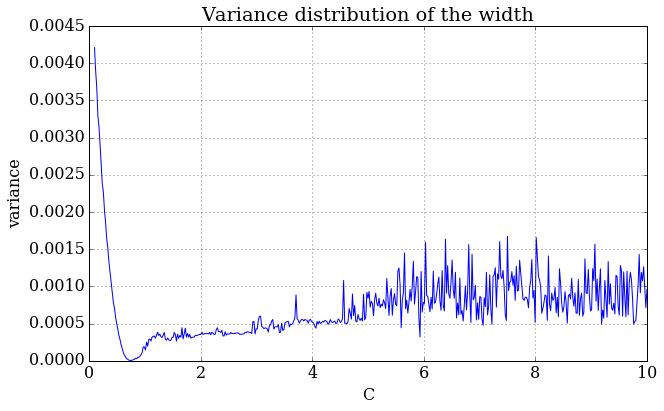

In [146]:
# sanity check plot
Cs = numpy.linspace(0.1, 10, 500)
vw = numpy.zeros(500)

# compute the variance for the C domain.
for i in range(500):
    vw[i] = min_width_C(Cs[i])

# plot results
pyplot.plot(Cs, vw)
pyplot.xlabel("C")
pyplot.ylabel("variance")
pyplot.title("Variance distribution of the width")
pyplot.grid(True)
pyplot.show()

In [91]:
def flock_animation(flock, dt, frames=10, xlim=(-0.1, 5), ylim=(-0.1, 5)):
    """
    Function which takes a flock of boids, and plots & animates their behaviour. 
    
    The function animates their behaviour, as they move on x & y axis over a set
    number of frames. Also, it displays the average width of the flock.
    
    @parameters
    flock - class @ __main__.Flock
        class containing all the agents from a flock, with their velocity & position. Has diferent methods
        which can be called
    
    dt - float
        timestep for which the animation step will proceed
        
    frames - int
        number of frames for which the animation will take places
        
    xlim - list
        list containing the boundaries on X axis for the animation
        
    ylim - list
        list containing the boudaries on Y axis for the animation
        
    @returns
    animation - matplotlib.animation.FuncAnimation
        the animation of the movement of the flock which will be displayed 
        
    Main author: Dr. Ian Hawke.
    """
    assert isinstance(flock, Flock), \
        "flock is not the Flock class. It is: {}".format(type(flock))
    assert type(dt) == int or type(dt) == float or type(dt) == numpy.float64, \
        "dt is not the recognised type. It is: {}.".format(type(dt))
        
    # produce the positions of the agents in the flock over the number of frames
    locations = [deepcopy(flock.locations())]
    ave_width = [flock.average_width()]
    ave_loc = [flock.average_location()]
    ave_vel = [flock.average_velocity()]
    times = numpy.arange(0.0, frames*dt, dt)
    for i in range(frames):
        flock.step(dt)
        locations.append(deepcopy(flock.locations()))
        ave_width.append(flock.average_width())
        ave_loc.append(flock.average_location())
        ave_vel.append(flock.average_velocity())
    
    # gather the dimensions for the average width plot
    max_width = max(ave_width)
    min_width = min(ave_width)
    d_width = max_width - min_width
    
    #stor plotting the movement of particles
    fig = pyplot.figure()
    ax1 = fig.add_subplot(121)
    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])
    points, = ax1.plot([], [], 'ro')
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    #start second plot of average width
    ax2 = fig.add_subplot(122)
    width, = ax2.plot([], [], 'b-')
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("Average width of flock")
    ax2.set_xlim(0.0, dt*frames)
    ax2.set_ylim(min_width-0.1*d_width, max_width+0.1*d_width)
    fig.tight_layout()
    pyplot.close()

    def init():
        """
        Method that initialises the starting positions of the particles & the avg width for the animation
        """
        points.set_data([], [])
        width.set_data([], [])
        """
        loc.set_data([], [])
        vel.set_data([], [])"""
        return (points, width)

    def animate(i):
        """
        Method that creates the ith frame for the animation.
        
        @parameter 
        i - int
            the frame number of the animation
        """
        points.set_data(locations[i][:,0], locations[i][:,1])
        width.set_data(times[:i+1], ave_width[:i+1])
        """loc.set_data([ave_loc[i][0]], [ave_loc[i][1]])
        vel.set_data([ave_vel[i][0]], [ave_vel[i][1]])"""
        return (points, width)
    
    return animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=frames, blit=True)

In [151]:
# animation for the test flock
flock = Flock(locations, vels, C=C_min)
HTML(flock_animation(flock, 0.1, int(t/dt), xlim=(-20.0,20.00), ylim=(-20.0,20)).to_html5_video())

In [172]:
# initialise the random 50 positions & velocities for the agents
locs_flock = numpy.random.random([50, 2]) * 5
vels_flock = numpy.array([1., 1.]) + 10**-2 * numpy.random.random([50, 2])

# create the random flock with the value of C obtained previously
flock_rand = Flock(locs_flock, vels_flock, C_min)

# animate the flock
HTML(flock_animation(flock_rand, 0.05, 200, xlim=(-20.0,20.0), ylim=(-20.0,20)).to_html5_video())

In [173]:
# create the random flock with the value of C obtained previously
flock_C_small = Flock(locs_flock, vels_flock, 0.5)

# animate the flock
HTML(flock_animation(flock_C_small, 0.05, 200, xlim=(-20.0,20.0), ylim=(-20.0,20)).to_html5_video())

In [174]:
# create the random flock with the value of C obtained previously
flock_C_big = Flock(locs_flock, vels_flock, 5)

# animate the flock
HTML(flock_animation(flock_C_big, 0.05, 200, xlim=(-20.0,20.0), ylim=(-20.0,20)).to_html5_video())

In [175]:
# create the random flock with the value of C obtained previously
flock_C_neg = Flock(locs_flock, vels_flock, -2)

# animate the flock
HTML(flock_animation(flock_C_neg, 0.05, 200, xlim=(-20.0,20.0), ylim=(-20.0,20)).to_html5_video())

### Discussion

The value of C, required to be calculated, is a component in the cost function. It is part of the equation that is defined by the angle of the position. 

A minimum C in the function will define a minimum distance between close particles. As such, it can be seen in the figure above, that different values of C produce a wide range of variances in the average width of test set of particles. The average width is defined by the distance between particles, and a smaller variance in the average width over the propagation time implies that the particles will diverge less. 
A higher value for C will imply that the particles will stay together more, while a smaller values will enable neighbouring particles to diverge.

As such, from the graph, it can be seen that the smallest variance in width is obtained for a C~0.75. This is confirmed by using a minimisation algortihm, obtaining C=0.7589.

Applying this minimum value of C to a random set of boids (a flock of 50 particles), should enable the particles close to each other (the distance is defined as rl=1) to stay together in groups. The overall group should diverge in a small number of groups, as the particles on one side will tend to group together, and the particles on the other side follow the same behaviour. However, the average of each group will tend to a minimum, while the overall average width will be minimised (less drifting). It can be seen in the second animation that such behaviour is followed. 
A smaller value of C will determine to particles to still group. However, the average width of each group will not tend to a minimum. Moveover, a negative value of C will determine the entire flock to diverge, not grouping. This behaviour is seen in the 3rd and 5th animation.
Having a higher value of C will determine the particles to form small groups of high densities, which then tend to drift off more than in the case of C minimum. Animation 4 presents this behaviour.   

## Finite elements - the big G

Solve the heat equation

$$
  \nabla^2 T + f(x, y) = 0
$$

on the domain $\Omega$, where $\Omega$ looks like the figure below:

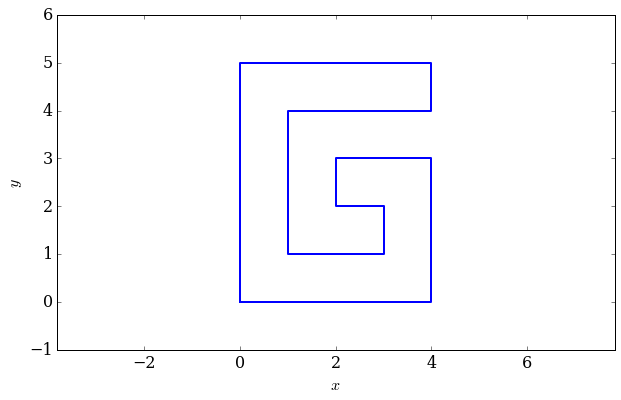

In [4]:
domain = numpy.array([[0.0, 0.0], [4.0, 0.0], [4.0, 3.0], [2.0, 3.0], [2.0, 2.0], [3.0, 2.0], [3.0, 1.0],
                      [1.0, 1.0], [1.0, 4.0], [4.0, 4.0], [4.0, 5.0], [0.0, 5.0], [0.0, 0.0]])
pyplot.figure(figsize=(10,6))
pyplot.plot(domain[:,0],domain[:,1], lw=2)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()

The temperature $T$ is fixed to be $1$ along the whole right boundary where $x=4$. On all other boundaries the normal derivative of the temperature vanishes. The heat source $f(x, y)$ is given by

$$
  f = \exp(-(x^2 + y^2)).
$$

### Tasks

1. Using the grid generation function below, and a finite element algorithm using linear elements as in the lab, compute and plot the solution of the heat equation with triangles of side-length $1/2$ and $1/16$.

#### Grid generation

In [203]:
def find_node_index_of_location(nodes, location):
    """
    Given all the nodes and a location (that should be the location of *a* node), return the index of that node.
    
    Parameters
    ----------
    
    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    location : array of float
        (2,) array containing the x, y coordinates of location
    """
    dist_to_location = numpy.linalg.norm(nodes - location, axis=1)
    return numpy.argmin(dist_to_location)
                

def generate_g_grid(side_length):
    """
    Generate a 2d triangulation of the letter G. All triangles have the same size (right triangles, 
    short length side_length)
    
    Parameters
    ----------
    
    side_length : float
        The length of each triangle. Should be 1/N for some integer N
    
    Returns
    -------
    
    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    IEN : array of int
        (Nelements, 3) array linking element number to node number
    ID : array of int
        (Nnodes,) array linking node number to equation number; value is -1 if node should not appear in global arrays.
    """
    x = numpy.arange(0, 4+0.5*side_length, side_length)
    y = numpy.arange(0, 5+0.5*side_length, side_length)
    X, Y = numpy.meshgrid(x,y)
    potential_nodes = numpy.zeros((X.size,2))
    potential_nodes[:,0] = X.ravel()
    potential_nodes[:,1] = Y.ravel()
    xp = potential_nodes[:,0]
    yp = potential_nodes[:,1]
    nodes_mask = numpy.logical_or(numpy.logical_and(xp>=2,numpy.logical_and(yp>=2,yp<=3)),
                                  numpy.logical_or(numpy.logical_and(xp>=3,yp<=3),
                                                   numpy.logical_or(xp<=1,
                                                                    numpy.logical_or(yp<=1, yp>=4))))
    nodes = potential_nodes[nodes_mask, :]
    ID = numpy.zeros(len(nodes), dtype=numpy.int)
    n_eq = 0
    for nID in range(len(nodes)):
        if numpy.allclose(nodes[nID,0], 4):
            ID[nID] = -1
        else:
            ID[nID] = n_eq
            n_eq += 1
    inv_side_length = int(1 / side_length)
    Nelements_per_block = inv_side_length**2
    Nelements = 2 * 14 * Nelements_per_block
    IEN = numpy.zeros((Nelements,3), dtype=numpy.int)
    block_corners = [[0,0], [1,0], [2,0], [3,0],
                     [0,1],               [3,1],
                     [0,2],        [2,2], [3,2],
                     [0,3],
                     [0,4], [1,4], [2,4], [3,4]]
    current_element = 0
    for block in block_corners:
        for i in range(inv_side_length):
            for j in range(inv_side_length):
                node_locations = numpy.zeros((4,2))
                for a in range(2):
                    for b in range(2):
                        node_locations[a+2*b,0] = block[0] + (i+a)*side_length
                        node_locations[a+2*b,1] = block[1] + (j+b)*side_length
                index_lo_l = find_node_index_of_location(nodes, node_locations[0,:])
                index_lo_r = find_node_index_of_location(nodes, node_locations[1,:])
                index_hi_l = find_node_index_of_location(nodes, node_locations[2,:])
                index_hi_r = find_node_index_of_location(nodes, node_locations[3,:])
                IEN[current_element, :] = [index_lo_l, index_lo_r, index_hi_l]
                current_element += 1
                IEN[current_element, :] = [index_lo_r, index_hi_r, index_hi_l]
                current_element += 1
    return nodes, IEN, ID

### Generate the auxiliary functions

In [204]:
def shape_f(xi, eta):
    """
    Function that returns the shape function at the given (local) location. 
    
    @parameters:
    xi - float
        the first coordinate of the reference element
        
    eta - float
        the second coordinate of the reference element
        
    @return:
    N - np array (3,)
        array containing the position of the reference element based on its coordinates. 
    """
    assert type(xi) == int or type(xi) == float or type(xi) == numpy.float64, \
        "xi not the proper type. Xi's current type is: {}.".format(type(xi))
        
    assert type(eta) == int or type(eta) == float or type(eta) == numpy.float64, \
        "Eta not the proper type. Eta's current type is: {}.".format(type(eta))
        
    return numpy.array([1 - eta - xi, xi, eta])


def d_shape_f():
    """
    Function that returns the derivative of the shape function with respect to both eta & xi. 
    
    @Parameters:
    None - as the derivative is calculated manually.
    
    Returns:
    dN - np array (2,3)
        array containing the derivative of the shape function with respect to xi (first row) and eta (second row).
        
    dN = [xi]
         [eta]
    """
    return numpy.array([[-1, 1, 0], [-1, 0, 1]])


def l2g(X, xi, eta):
    """
    Function that returns the global coordinates, given a of local coordinates (X) and the position
    of the reference element.
      
    @parameters:
    
    X - numpy array (3,2)
        array containing the global position of the corners of the required element, as an array containg the X & Y 
        global coordinates of each of the 3 points contained in the element.
    X = [x0, y0]
        [x1, y1]
        [x2, y2]
    
    xi - float
        the first coordinate of the reference element
        
    eta - float
        the second coordinate of the reference element
        
    @return:
    coords - np array (2,)
        array containing the global position of the element
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. X is a: {}.".format(type(X))
    assert X.shape == (3,2), \
        "X does not have the correct shape. Its current shape is: {}.".format(X.shape)
        
    assert type(xi) == int or type(xi) == float or type(xi) == numpy.float64, \
        "xi not the proper type. Xi's current type is: {}.".format(type(xi))
        
    assert type(eta) == int or type(eta) == float or type(eta) == numpy.float64, \
        "Eta not the proper type. Eta's current type is: {}.".format(type(eta))
        
    N_loc = shape_f(xi, eta)
    x = (X[:, 0] * N_loc).sum()
    y = (X[:, 1] * N_loc).sum()
    return numpy.array([x, y])


def jacobian(X, xi, eta):
    """
    Function that returns the the Jacobian matrix at the position of an element,
    given its corners coordinates. 
    
    @parameters:
    
    X - numpy array (3,2)
        array containing the global position of the corners of the required element, as an array containg the X & Y 
        global coordinates of each of the 3 points contained in the element.
    X = [x0, y0]
        [x1, y1]
        [x2, y2]
    
    xi - float
        the first coordinate of the reference element
        
    eta - float
        the second coordinate of the reference element
        
    @return:
    J = [d_xi * x    d_eta * x]
        [d_xi * y    d_eta * y]
      - np array (2, 2)
        numpy array containing the Jacobian matrix at that location
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. X is a: {}.".format(type(X))
    assert X.shape == (3,2), \
        "X does not have the correct shape. Its current shape is: {}.".format(X.shape)
        
    assert type(xi) == int or type(xi) == float or type(xi) == numpy.float64, \
        "xi not the proper type. Xi's current type is: {}.".format(type(xi))
        
    assert type(eta) == int or type(eta) == float or type(eta) == numpy.float64, \
        "Eta not the proper type. Eta's current type is: {}.".format(type(eta))
        
    dN = d_shape_f()
    return numpy.array([[(X[:, 0] * dN[0]).sum(), (X[:, 1] * dN[0]).sum()],
                       [(X[:, 0] * dN[1]).sum(), (X[:, 1] * dN[1]).sum()]])
    
    
def det_jacobian(X, xi, eta):
    """
    Function that given the (global) locations X of the nodes of a triangular element 
    and the local coordinates xi & eta , returns the determinant of the Jacobian matrix at that location.
    
    @parameters:
    
    X - numpy array (3,2)
        array containing the global position of the corners of the required element, as an array containg the X & Y 
        global coordinates of each of the 3 points contained in the element.
    X = [x0, y0]
        [x1, y1]
        [x2, y2]
    
    xi - float
        the first coordinate of the reference element
        
    eta - float
        the second coordinate of the reference element
        
    @return:
    dJ - float
        determinant of Jacobian matrix
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. X is a: {}.".format(type(X))
    assert X.shape == (3,2), \
        "X does not have the correct shape. Its current shape is: {}.".format(X.shape)
        
    assert type(xi) == int or type(xi) == float or type(xi) == numpy.float64, \
        "xi not the proper type. Xi's current type is: {}.".format(type(xi))
        
    assert type(eta) == int or type(eta) == float or type(eta) == numpy.float64, \
        "Eta not the proper type. Eta's current type is: {}.".format(type(eta))
        
    return numpy.linalg.det(jacobian(X, xi, eta))


def dx_shape_f(X, xi, eta):
    """
    Function that, given the (global) locations X of the nodes of a triangular
    element and the local coordinates xi & eta within the element returns the derivatives 
    of the shape function with respect to x & y (coordinates of the nodes). 
    Can be also interpreted as global derivatives from local coordinates. 
    
    @parameters:
    
    X - numpy array (3,2)
        array containing the global position of the corners of the required element, as an array containg the X & Y 
        global coordinates of each of the 3 points contained in the element.
    X = [x0, y0]
        [x1, y1]
        [x2, y2]
    
    xi - float
        the first coordinate of the reference element
        
    eta - float
        the second coordinate of the reference element
        
    @return:
    delta N - np array (3, 2)
            array containing the global derivatives computed from local coordinates. 
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. X is a: {}.".format(type(X))
    assert X.shape == (3,2), \
        "X does not have the correct shape. Its current shape is: {}.".format(X.shape)
        
    assert type(xi) == int or type(xi) == float or type(xi) == numpy.float64, \
        "xi not the proper type. Xi's current type is: {}.".format(type(xi))
        
    assert type(eta) == int or type(eta) == float or type(eta) == numpy.float64, \
        "Eta not the proper type. Eta's current type is: {}.".format(type(eta))
        
    J = jacobian(X, xi, eta)
    dN = d_shape_f()
    return numpy.linalg.solve(J, dN)


def quad_psi(psi):
    """
    Function that given another function psi, returns the quadrature of psi over the reference
    triangle. 
    
    @Parameters
    psi - function
        a function psi to be given later in the program. It is mainly used in calculating the stifness
        and force of each element
        
    @Return
    I - float
        the quadrature of psi over the reference triangle
    """
    assert isinstance(psi, types.FunctionType), \
        "Psi is not a function. It is {}.".format(type(psi))
    # reference element position
    xi1 = numpy.array([1/6, 1/6])
    xi2 = numpy.array([4/6, 1/6])
    xi3 = numpy.array([1/6, 4/6])
    I = (psi(xi1) + psi(xi2) + psi(xi3)) / 6
    assert type(I) == float or type(I) == int or type(I) == numpy.float64, \
        "Something went wrong in quad_psi. I is not a float, it is {}.".format(type(I))
    return I


def volume_quad_elem(X, phi):
    """
    Function that, given the (global) locations of the nodes of a triangular element (X)
    and a function phi, returns the quadrature of phi over the element.
    
    @Parameters
    X - numpy array (3,2)
        array containing the global position of the corners of the required element, as an array containg the X & Y 
        global coordinates of each of the 3 points contained in the element.
    X = [x0, y0]
        [x1, y1]
        [x2, y2]
        
    phi - function
        function used to return the quadrature of phi over the element. Used in calculating the gradient
        phi over a successive number of elements
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. X is a: {}.".format(type(X))
    assert X.shape == (3,2), \
        "X does not have the correct shape. Its current shape is: {}.".format(X.shape)
    assert isinstance(phi, types.FunctionType), \
        "Phi is not a function. It is {}.".format(type(phi))
    
    psi = lambda xi : det_jacobian(X, xi[0], xi[1]) * phi(l2g(X, xi[0], xi[1]),
                                                      shape_f(xi[0], xi[1]),
                                                      dx_shape_f(X, xi[0], xi[1]))
    return quad_psi(psi)

#### Generate the tests for the auxiliary functions

In [191]:
def test_shape_f():
    # test wrong inputs
    try:
        shape_f("a", 2)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("xi", e))
    try:
        shape_f(2, "a")
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("eta", e))
    print("passed wrong inputs test")
    
    N = shape_f(0.5, 0.4)
    assert (N.shape == (3,)), \
        "Not the correct shape"
    assert numpy.allclose(N, numpy.array([0.1, 0.5, 0.4])), \
        "the values were not created properly"
    
    # test against the tutorial values
    location = numpy.array([1/6,1/6])
    assert (numpy.allclose(shape_f(location[0], location[1]), [0.66666667, 0.16666667, 0.16666667])), \
        "the values do not check up."
    print("passed the tests against class.")
test_shape_f()

AssertionError was raised when xi was given a different type than expected. 
 Error: xi not the proper type. Xi's current type is: <class 'str'>..
AssertionError was raised when eta was given a different type than expected. 
 Error: Eta not the proper type. Eta's current type is: <class 'str'>..
passed wrong inputs test
passed the tests against class.


In [194]:
def test_d_shape_f():
    # this function does not require much testing
    assert (d_shape_f().shape == (2,3)), \
        "Not created the proper shape."
    assert (d_shape_f() == numpy.array([[-1, 1, 0], [-1, 0, 1]])).all(), \
        "Not created the proper values."
    print("tests passed")
    
test_d_shape_f()

tests passed


In [200]:
def test_l2g():
    length = 1.0
    nodes = numpy.array([[0.0, 0.0], [length, 0.0], [0.0, length], [length, length]])
    IEN = numpy.array([[0, 1, 2], 
                   [1, 3, 2]])
    nodes_0 = nodes[IEN[0,:],:]
    nodes_1 = nodes[IEN[1,:],:]
    location = numpy.array([1/6,1/6])
    
    # test wrong inputs
    try:
        l2g("a", location[0], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    try:
        l2g(nodes_0, [2], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("xi", e))
    try:
        l2g(nodes_0, location[0], ['a'])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("eta", e))
    print("passed wrong inputs")
    
    # test against class example
    assert numpy.allclose(l2g(nodes_0, location[0], location[1]), [0.16666667, 0.16666667]), \
        "first try went wrong."
    assert numpy.allclose(l2g(nodes_1, location[0], location[1]), [0.83333333, 0.33333333]), \
        "second try went wrong."
    print("passed value tests.")
        
test_l2g()

AssertionError was raised when nodes was given a different type than expected. 
 Error: X is not a numpy array. X is a: <class 'str'>..
AssertionError was raised when xi was given a different type than expected. 
 Error: xi not the proper type. Xi's current type is: <class 'list'>..
AssertionError was raised when eta was given a different type than expected. 
 Error: Eta not the proper type. Eta's current type is: <class 'list'>..
passed wrong inputs
passed value tests.


In [202]:
def test_jacobian():
    length = 1.0
    nodes = numpy.array([[0.0, 0.0], [length, 0.0], [0.0, length], [length, length]])
    IEN = numpy.array([[0, 1, 2], 
                   [1, 3, 2]])
    nodes_0 = nodes[IEN[0,:],:]
    nodes_1 = nodes[IEN[1,:],:]
    location = numpy.array([1/6,1/6])
    
    # test wrong inputs
    try:
        jacobian("a", location[0], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    try:
        jacobian(nodes_0, [2], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("xi", e))
    try:
        jacobian(nodes_0, location[0], ['a'])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("eta", e))
    print("passed wrong inputs")
    
    # test against class values
    assert numpy.allclose(jacobian(nodes_0, location[0], location[1]), [[1., 0.], [0., 1.]]), \
        print("first try went wrong")
    assert numpy.allclose(jacobian(nodes_1, location[0], location[1]), [[0., 1.], [-1., 1.]]), \
        print("second try went wrong")
    print("value tests passed.")
    
test_jacobian()

AssertionError was raised when nodes was given a different type than expected. 
 Error: X is not a numpy array. X is a: <class 'str'>..
AssertionError was raised when xi was given a different type than expected. 
 Error: xi not the proper type. Xi's current type is: <class 'list'>..
AssertionError was raised when eta was given a different type than expected. 
 Error: Eta not the proper type. Eta's current type is: <class 'list'>..
passed wrong inputs
value tests passed.


In [208]:
def test_det_jacobian():
    length = 1.0
    nodes = numpy.array([[0.0, 0.0], [length, 0.0], [0.0, length], [length, length]])
    IEN = numpy.array([[0, 1, 2], 
                   [1, 3, 2]])
    nodes_0 = nodes[IEN[0,:],:]
    nodes_1 = nodes[IEN[1,:],:]
    location = numpy.array([1/6,1/6])
    
    # test wrong inputs
    try:
        det_jacobian("a", location[0], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    try:
        det_jacobian(nodes_0, [2], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("xi", e))
    try:
        det_jacobian(nodes_0, location[0], ['a'])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("eta", e))
    print("passed wrong inputs")
    
    # test against class values
    assert det_jacobian(nodes_0, location[0], location[1]) == 1.0, \
        print("first test went wrong")
    assert det_jacobian(nodes_1, location[0], location[1]) == 1.0, \
        print("second test went wrong")
    print("passed value tests.")
    
test_det_jacobian()

AssertionError was raised when nodes was given a different type than expected. 
 Error: X is not a numpy array. X is a: <class 'str'>..
AssertionError was raised when xi was given a different type than expected. 
 Error: xi not the proper type. Xi's current type is: <class 'list'>..
AssertionError was raised when eta was given a different type than expected. 
 Error: Eta not the proper type. Eta's current type is: <class 'list'>..
passed wrong inputs
passed value tests.


In [210]:
def test_dx_shape_f():
    length = 1.0
    nodes = numpy.array([[0.0, 0.0], [length, 0.0], [0.0, length], [length, length]])
    IEN = numpy.array([[0, 1, 2], 
                   [1, 3, 2]])
    nodes_0 = nodes[IEN[0,:],:]
    nodes_1 = nodes[IEN[1,:],:]
    location = numpy.array([1/6,1/6])
    
    # test wrong inputs
    try:
        dx_shape_f("a", location[0], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    try:
        dx_shape_f(nodes_0, [2], location[1])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("xi", e))
    try:
        dx_shape_f(nodes_0, location[0], ['a'])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("eta", e))
    print("passed wrong inputs")
    
    # test against class values
    assert numpy.allclose(dx_shape_f(nodes_0, location[0], location[1]), [[-1., 1., 0.], [-1., 0., 1.]]), \
        print("first test went wrong")
    assert numpy.allclose(dx_shape_f(nodes_1, location[0], location[1]), [[-0., 1., -1.], [-1., 1., 0.]]), \
        print("second test went wrong")
    print("passed value tests.")
    
test_dx_shape_f()

AssertionError was raised when nodes was given a different type than expected. 
 Error: X is not a numpy array. X is a: <class 'str'>..
AssertionError was raised when xi was given a different type than expected. 
 Error: xi not the proper type. Xi's current type is: <class 'list'>..
AssertionError was raised when eta was given a different type than expected. 
 Error: Eta not the proper type. Eta's current type is: <class 'list'>..
passed wrong inputs
passed value tests.


In [212]:
def test_quad_psi():
    def psi_1(xi):
        return 1.0

    def psi_xi(xi):
        return xi[0]

    def psi_eta(xi):
        return xi[1]

    def psi_xi_eta(xi):
        return 1-xi[0]-xi[1]
    
    # test wrong variables
    try:
        quad_psi("a")
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("psi", e))
    print("wrong variables test passed")
    
    # test against class example 
    assert numpy.allclose(quad_psi(psi_1), 0.5), \
        "first test failed"
    assert numpy.allclose(quad_psi(psi_xi), 0.166666666667), \
        "second test failed"
    assert numpy.allclose(quad_psi(psi_eta), 0.166666666667), \
        "third test failed"
    assert numpy.allclose(quad_psi(psi_xi_eta), 0.166666666667), \
        "fourth test failed"
    print("passed value tests")
    
test_quad_psi()

AssertionError was raised when psi was given a different type than expected. 
 Error: Psi is not a function. It is <class 'str'>..
wrong variables test passed
passed value tests


In [215]:
def test_volume_quad_elem():
    def psi_1_g(x, N, dN):
        return 1.0

    def psi_x(x, N, dN):
        return x[0]

    def psi_y(x, N, dN):
        return x[1]

    def psi_x_y(x, N, dN):
        return 1-x[0]-x[1]
    length = 1.0
    nodes = numpy.array([[0.0, 0.0], [length, 0.0], [0.0, length], [length, length]])
    IEN = numpy.array([[0, 1, 2], 
                   [1, 3, 2]])
    nodes_0 = nodes[IEN[0,:],:]
    nodes_1 = nodes[IEN[1,:],:]
    
    # test wrong inputs
    try:
        volume_quad_elem("a", psi_y)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("X", e))
    try:
        volume_quad_elem(nodes_0, "a")
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("psi", e))
    print("wrong inputs test passed")
    
    # test numerical values against class examples
    assert numpy.allclose(volume_quad_elem(nodes_0, psi_1_g), 0.5), \
        "element 0 first test failed"
    assert numpy.allclose(volume_quad_elem(nodes_0, psi_x), 0.166666666667), \
        "element 0 second test failed"
    assert numpy.allclose(volume_quad_elem(nodes_0, psi_y), 0.166666666667), \
        "element 0 third test failed"
    assert numpy.allclose(volume_quad_elem(nodes_0, psi_x_y), 0.166666666667), \
        "element 0 fourth test failed"
    assert numpy.allclose(volume_quad_elem(nodes_1, psi_1_g), 0.5), \
        "element 1 first test failed"
    assert numpy.allclose(volume_quad_elem(nodes_1, psi_x), 0.333333333333), \
        "element 1 second test failed"
    assert numpy.allclose(volume_quad_elem(nodes_1, psi_y), 0.333333333333), \
        "element 1 third test failed"
    assert numpy.allclose(volume_quad_elem(nodes_1, psi_x_y), -0.166666666667), \
        "element 1 fourth test failed"
    print("passed numerical tests")

test_volume_quad_elem()

AssertionError was raised when X was given a different type than expected. 
 Error: X is not a numpy array. X is a: <class 'str'>..
AssertionError was raised when psi was given a different type than expected. 
 Error: Phi is not a function. It is <class 'str'>..
wrong inputs test passed
passed numerical tests


### Create the stiffness and force functions & test them

In [216]:
def stiffness(nodes):
    """
    Function that compute the coefficients of the stiffness matrix for a single element. 
    Having the nodes of an element, the stiffness coefficient is calculated using the formula:
    k_ab_e = integrate over element delem (pd_xNa(x,y) * pd_yNb(x, y) + pd_yNa(x,y) * pd_yNb(x, y))
    
    where pd_xNa is the partial derivative with respect to x of Na. Similar logic applied to the remaining notations.
    
    Parameters
    nodes - np array (2,3)
        array containing the coordinates of the nodes that construct the element.
        
    Returns
    k_e - numpy array (3,3)
        the stiffness matrix of the element
    """
    assert type(nodes) == numpy.ndarray, \
        "nodes is not a numpy array. X is a: {}.".format(type(nodes))
    assert nodes.shape == (3,2), \
        "nodes does not have the correct shape. Its current shape is: {}.".format(nodes.shape)
        
    k_e = numpy.zeros((3,3))
    for a in range(3):
        for b in range(3):
            # create the auxiliary phi_k function to calculate the stiffness, as described in the exercise.
            def phi_k(x, N, dN):
                return dN[0, a] * dN[0, b] + dN[1, a] * dN[1, b]
            k_e[a, b] = volume_quad_elem(nodes, phi_k)
    return k_e

In [217]:
def force(nodes, f):
    """
    Function to compute the coefficients of the force vector for a single element, based on the function f.
    Having the nodes, the force coefficient are calculated using:
    f_b_e = integrate over element delem(Nb(x,y) * f(x, y))
    
    Parameters
    nodes - np array (2,3)
        array containing the coordinates of the nodes that construct the element.
    
    f - function
        driving function for the force creation
        
    Returns
    f_e - numpy array (3,)
            array containing the force exerted on each of the nodes of the element. 
    """
    assert type(nodes) == numpy.ndarray, \
        "nodes is not a numpy array in force. X is a: {}.".format(type(nodes))
    assert nodes.shape == (3,2), \
        "nodes does not have the correct shape in force. The shape is {}.".format(nodes.shape)
        
    assert isinstance(f, types.FunctionType), \
        "f is not a function in force. It is a {}.".format(type(f))
        
    f_e = numpy.zeros(3)
    for i in range(3):
        # create the auxiliary phi_f function to calculate the force
        def phi_f(x, N, dN):
            return N[i] * f(x)
        f_e[i] = volume_quad_elem(nodes, phi_f)
        
    assert (f_e.shape) == (3,), \
        "f_e was not created properly. Its shape is {}.".format(f_e.shape)
    assert (f_e != 0).any(), \
        "f_e was not created properly. It has all values equal to 0."
    return f_e

#### Testing stiffness & force

In [221]:
def test_stiffness():
    nodes = numpy.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
    IEN = numpy.array([[0, 1, 2], 
                       [1, 3, 2]])
    
    # test wrong inputs
    try:
        stiffness("a")
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    try:
        stiffness([1,2,3])
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    try:
        stiffness(2)
    except AssertionError as e:
        print("AssertionError was raised when {} was given a different type than expected. \n Error: {}.".format("nodes", e))
    print("passed wrong inputs tests")
    
    # test solution against class values
    assert numpy.allclose(stiffness(nodes[IEN[0, :]]), [[ 1. , -0.5, -0.5],
                                                       [-0.5,  0.5,  0. ],
                                                       [-0.5,  0. ,  0.5]]), \
        "wrong values for outputs were created."
    print("passed value tests.")
    
test_stiffness()

AssertionError was raised when nodes was given a different type than expected. 
 Error: nodes is not a numpy array. X is a: <class 'str'>..
AssertionError was raised when nodes was given a different type than expected. 
 Error: nodes is not a numpy array. X is a: <class 'list'>..
AssertionError was raised when nodes was given a different type than expected. 
 Error: nodes is not a numpy array. X is a: <class 'int'>..
passed wrong inputs tests
passed value tests.


In [70]:
def fin_elem_2d(nodes, IEN, ID, f):
    """
    Function that takes the nodes that create the shape, the element node array, a set of IDs and a 
    function, and returns the solution of f for each element created by the nodes. 
    
    @Parameters:
    nodes - numpy array (N1, 2)
            array containing the X & Y position of each node in the mesh
            
    IEN - numpy array (N2, 3)
          array containing the IDs of the nodes that construct each element in the mesh
          
    ID - numpy array (N1,)
        array of IDs of the nodes from the mesh
        
    f - function
        function for which the mesh is evaluated. In this case is exp(-(x^2 + y^2))
        
    @Returns:
    T - numpy array (N1,)
        the solution of f for each element created by the nodes. 
    """
    assert type(nodes) == numpy.ndarray, \
        "nodes is not a numpy array in fin_elem_2d. X is a: {}.".format(type(nodes))
    assert nodes.shape[1] == 2, \
        "nodes does not have the correct shape in fin_elem_2d. The shape is {}.".format(nodes.shape)
    assert type(IEN) == numpy.ndarray, \
        "IEN is not a numpy array in fin_elem_2d. X is a: {}.".format(type(IEN))
    assert IEN.shape[1] == 3, \
        "IEN does not have the correct shape in fin_elem_2d. The shape is {}.".format(IEN.shape)
    assert type(ID) == numpy.ndarray, \
        "ID is not a numpy array in fin_elem_2d. X is a: {}.".format(type(ID))
    assert ID.shape[0] == nodes.shape[0], \
        "ID does not have the correct shape in fin_elem_2d. The shape is {}.".format(ID.shape)
    assert isinstance(f, types.FunctionType), \
        "f is not a function in fin_elem_2d. It is {}.".format(type(f))
    
    # gather the data on the number of nodes & elements
    N_equ = numpy.max(ID)+1
    N_elem = IEN.shape[0]
    N_nodes = nodes.shape[0]
    Ndim = nodes.shape[1]
    
    # Location matrix
    location_matrix = numpy.zeros_like(IEN.T)
    for elem in range(N_elem):
        for i in range(3):
            location_matrix[i,elem] = ID[IEN[elem,i]]
            
    # Global stiffness matrix and force vector
    K = numpy.zeros([N_equ, N_equ])
    F = numpy.zeros(N_equ)
    
    # Loop over elements
    for elem in range(N_elem):
        k_e = stiffness(nodes[IEN[elem,:],:])
        f_e = force(nodes[IEN[elem,:],:], f)
        for i in range(3):
            A = location_matrix[i, elem]
            for j in range(3):
                B = location_matrix[j, elem]
                if (A >= 0) and (B >= 0):
                    K[A, B] += k_e[i, j]
            if (A >= 0):
                F[A] += f_e[i]
    # Solve
    T_A = numpy.linalg.solve(K, F)
    T = numpy.zeros(N_nodes)
    for n in range(N_nodes):
        if ID[n] >= 0: # Otherwise T should be zero, and we've initialized that already.
            T[n] = T_A[ID[n]]
    assert T.shape == (N_nodes,), \
        "T does not have the same number of elements. Instead of {} it has {}.".format(N_nodes, T.shape)
        
    return T

In [72]:
def f(x):
    """
    The function f for this exercise. It dictates the heat propagation based on the location of the elements.
    f(x,y) = exp(-(x^2 + y^2))
    
    @Parameter:
    x - numpy array (2,)
        array containing the position on (X & Y) of the element for which f is computed.
        
    @Returns:
    f - float
        the solution of the equation.
    """
    assert x.shape == (2,), \
        "x is not the correct shape in f. It is {}.".format(x.shape)
        
    return numpy.exp(-(x[0] * x[0] + x[1] * x[1]))

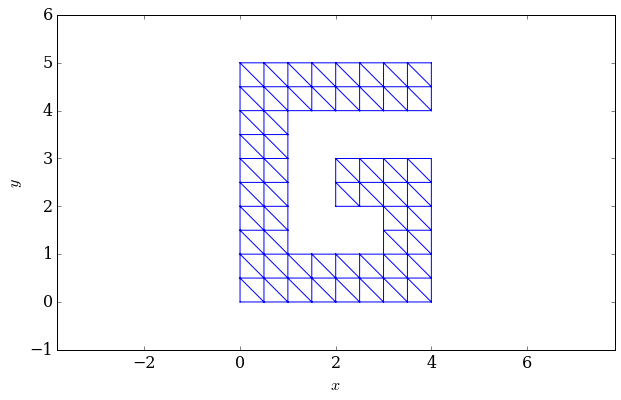

In [177]:
# create the nodes, the element node array & the IDs of the mesh for a side length of 0.5
nodes, IEN, ID = generate_g_grid(1/2)

# plot the mesh
pyplot.figure(figsize=(10,6))
pyplot.triplot(nodes[:,0], nodes[:,1], triangles=IEN, lw=1)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()

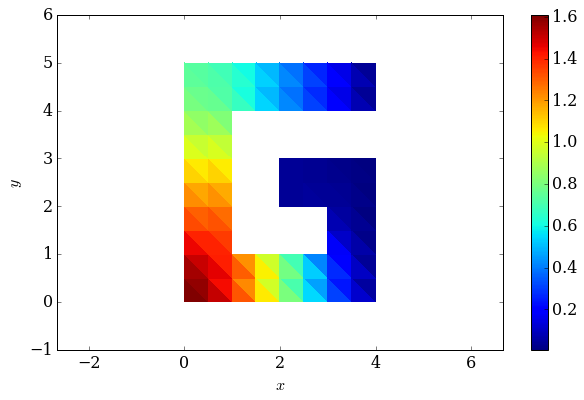

In [179]:
# calculate the solution for each element in the mesh created earlier, with sidelength of 1/2
T = fin_elem_2d(nodes, IEN, ID, f)

# plot the heat distribution in the mesh
pyplot.figure(figsize=(10,6))
pyplot.tripcolor(nodes[:,0], nodes[:,1], T, triangles=IEN)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.colorbar()
pyplot.show()

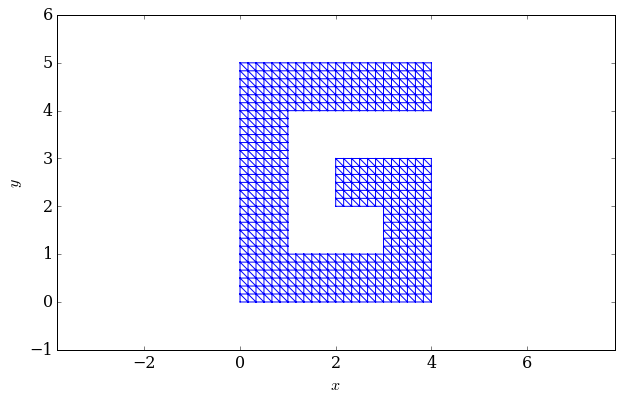

In [180]:
# create the nodes, the element node array & the IDs of the mesh for a side length of 1/6
nodes, IEN, ID = generate_g_grid(1/6)

# plot the mesh
pyplot.figure(figsize=(10,6))
pyplot.triplot(nodes[:,0], nodes[:,1], triangles=IEN, lw=1)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()

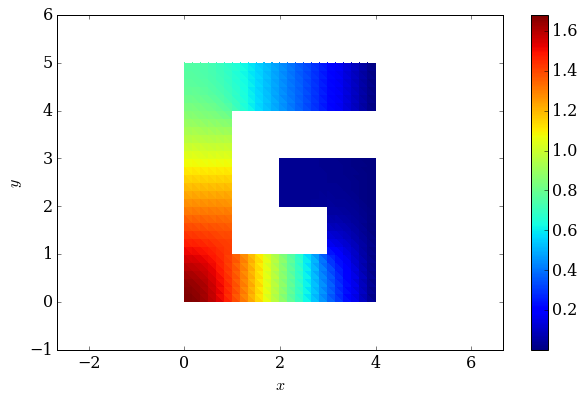

In [181]:
# calculate the solution for each element in the mesh created earlier, with sidelength of 1/2
T = fin_elem_2d(nodes, IEN, ID, f)

# plot the heat distribution in the mesh
pyplot.figure(figsize=(10,6))
pyplot.tripcolor(nodes[:,0], nodes[:,1], T, triangles=IEN)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.colorbar()
pyplot.show()